In [31]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import normflows as nf
import random
from torch.utils.data import DataLoader
import pandas as pd
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

from GPDFlow import T_mGPD_NF
import Common_Functions as cf
import pickle

Using device: cuda


In [2]:
# Directory for saving plots and the model weights in all repeated experiments. Not uploaded to GitHub for file size considerations.
dir_out = "/home/pgrad2/2448355h/My_PhD_Project/01_Output/GPDFlow/"

#### Parameter settings for the T-representation mGPD with reverse exponential 

In [42]:
n_samples = 100
n_experiments = 100    
d = 5
a = np.array([2, 0.5, 1, 5, 1.5]) # alpha = 1/a, which is requred in computing the bivariate tail dependence coefficient
beta = np.array([1, 2, 3, 4, 5])
sig = np.array([0.5, 1.2, 1, 1.5, 0.8])
gamma = np.array([-0.1, 0.2, 0, 0.15, -0.05])

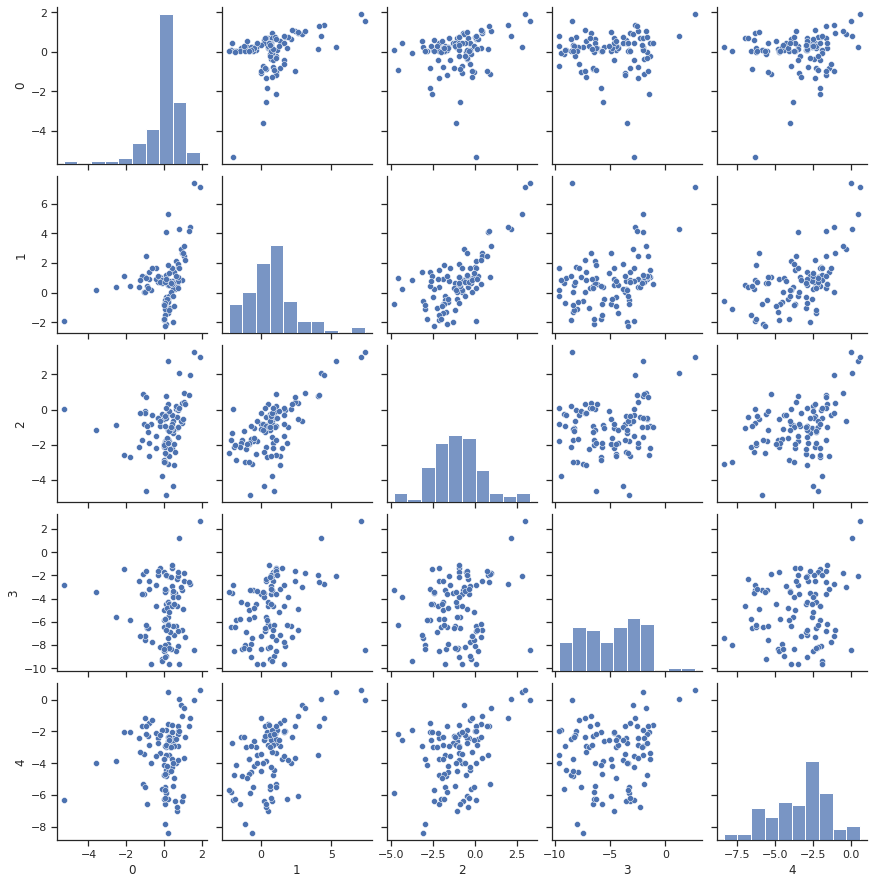

In [43]:
seed = 1234
random.seed(seed)
np.random.seed(seed)

samples = cf.sim_revexp_T_mgpd(n_samples, d, a, beta, sig, gamma)

sns.pairplot(pd.DataFrame(samples), diag_kws={'bins': 10})

#### Tuning Hyperparameters

In [44]:
rng = np.random.default_rng(seed)  # set seed for reproducibility (change/remove if you want)
idx = rng.permutation(len(samples))

split = int(0.8 * len(samples))
train_idx, val_idx = idx[:split], idx[split:]

train_samples = samples[train_idx]
val_samples   = samples[val_idx]

In [45]:
def build_realnvp_flow(dim: int, num_layers: int, hidden_mult: int, device):
    """
    Builds a RealNVP-like flow using MaskedAffineFlow + ActNorm blocks.
    hidden_mult controls the middle layer width: hidden_mult * latent_size
    """
    base = nf.distributions.DiagGaussian(dim)
    latent_size = dim
    b = torch.Tensor([1 if i % 2 == 0 else 0 for i in range(latent_size)]).to(device)

    flows = []
    for i in range(num_layers):
        hidden = hidden_mult * latent_size
        s = nf.nets.MLP([latent_size, hidden, latent_size], init_zeros=True, output_fn='tanh')
        t = nf.nets.MLP([latent_size, hidden, latent_size], init_zeros=True, output_fn='tanh')
        if i % 2 == 0:
            flows += [nf.flows.MaskedAffineFlow(b, t, s)]
        else:
            flows += [nf.flows.MaskedAffineFlow(1 - b, t, s)]
        flows += [nf.flows.ActNorm(latent_size)]

    flow_model = nf.NormalizingFlow(base, flows).to(device)
    return flow_model

def train_one_setting(
    *,
    dim: int,
    num_layers: int,
    hidden_mult: int,
    device,
    train_samples,
    val_samples,
    seed: int = 1234,
    epochs: int = 200,
    batch_size: int = 64,
    patience: int = 100,
    min_delta: float = 0.0,
    weight_decay: float = 1e-5,
    lr_flow: float = 1e-2,
    lr_log_sigma: float = 1e-1,
    lr_theta: float = 1e-1,
):
    """
    Returns:
      result dict with:
        best_val, best_epoch, final_epoch, histories, and best_state (CPU tensors)
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

    # tensors + loaders
    train_data = torch.tensor(np.asarray(train_samples), dtype=torch.float32, device=device)
    val_data   = torch.tensor(np.asarray(val_samples),   dtype=torch.float32, device=device)
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True,  drop_last=False)
    val_loader   = DataLoader(val_data,   batch_size=batch_size, shuffle=False, drop_last=False)

    # build flow + wrapper model
    f_T_model = build_realnvp_flow(dim=dim, num_layers=num_layers, hidden_mult=hidden_mult, device=device)

    model = T_mGPD_NF(
        dim=dim,
        flow=f_T_model,
        device=device,
        s_min=-10,
        s_max=10,
        num_integration_points=1000,
        penalty_lambda=10000,
        fix_margin=False
    ).to(device)

    optimizer = torch.optim.Adam(
        [
            {'params': model.flow_model.parameters(), 'lr': lr_flow},
            {'params': model.data_transform.log_sigma, 'lr': lr_log_sigma},
            {'params': model.data_transform.theta,     'lr': lr_theta},
        ],
        weight_decay=weight_decay
    )
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs)

    best_val = float("inf")
    best_state = None
    best_epoch = -1
    bad_epochs = 0

    train_hist, val_hist = [], []

    torch.autograd.set_detect_anomaly(True)

    for epoch in range(epochs):
        # ---------------- TRAIN ----------------
        model.train()
        train_epoch_loss = 0.0
        train_count = 0

        for x_data in train_loader:
            batch_loss = model(x_data)

            if torch.isnan(batch_loss) or torch.isinf(batch_loss):
                print(f"[Grid] NaN/Inf in TRAIN | layers={num_layers} hidden_mult={hidden_mult} epoch={epoch}")
                bad_epochs = patience  # force stop
                break

            optimizer.zero_grad(set_to_none=True)
            batch_loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            bsz = x_data.shape[0]
            train_epoch_loss += batch_loss.item() * bsz
            train_count += bsz

        train_epoch_loss = train_epoch_loss / max(train_count, 1)
        train_hist.append(train_epoch_loss)

        # ---------------- VALIDATION ----------------
        model.eval()
        val_epoch_loss = 0.0
        val_count = 0
        with torch.no_grad():
            for x_val in val_loader:
                vloss = model(x_val)
                if torch.isnan(vloss) or torch.isinf(vloss):
                    print(f"[Grid] NaN/Inf in VAL | layers={num_layers} hidden_mult={hidden_mult} epoch={epoch}")
                    bad_epochs = patience
                    break
                bsz = x_val.shape[0]
                val_epoch_loss += vloss.item() * bsz
                val_count += bsz

        val_epoch_loss = val_epoch_loss / max(val_count, 1)
        val_hist.append(val_epoch_loss)

        scheduler.step()

        # ---------------- EARLY STOPPING on VAL ----------------
        improved = (best_val - val_epoch_loss) > min_delta
        if improved:
            best_val = val_epoch_loss
            best_epoch = epoch
            bad_epochs = 0
            # keep best weights for this hyperparam setting
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
        else:
            bad_epochs += 1

        # optional logging per epoch (comment out if too chatty)
        # print(f"[Grid] layers={num_layers:2d} hidden_mult={hidden_mult:2d} "
        #       f"epoch={epoch+1:3d}/{epochs} train={train_epoch_loss:.6f} val={val_epoch_loss:.6f}")

        if bad_epochs >= patience:
            break

    result = {
        "num_layers": num_layers,
        "hidden_mult": hidden_mult,
        "best_val": float(best_val),
        "best_epoch": int(best_epoch),
        "final_epoch": int(epoch),
        "train_history": train_hist,
        "val_history": val_hist,
        "best_state": best_state,  # CPU tensors
    }
    return result

# ----------------------------
# DEFINE YOUR GRID
# ----------------------------
num_layers_grid = [4, 8, 12, 16]      # example; edit as desired
hidden_mult_grid = [2, 4, 6, 8]          # middle layer = hidden_mult * latent_size

# ----------------------------
# RUN GRID SEARCH
# ----------------------------
grid_results = []
best_overall = None

dim = d
batch_size = 64
epochs = 200
patience = 50          # how many epochs w/o improvement before stopping
min_delta = 0.0        # minimum improvement to reset patience
best_val = float("inf")
best_state = None
bad_epochs = 0

for nl in num_layers_grid:
    for hm in hidden_mult_grid:
        print(f"\n=== Training setting: num_layers={nl}, hidden_mult={hm} ===")
        res = train_one_setting(
            dim=dim,
            num_layers=nl,
            hidden_mult=hm,
            device=device,
            train_samples=train_samples,
            val_samples=val_samples,
            seed=seed,
            epochs=epochs,
            batch_size=batch_size,
            patience=patience,
            min_delta=min_delta,
            weight_decay=1e-5,
            lr_flow=1e-2,
            lr_log_sigma=1e-1,
            lr_theta=1e-1,
        )
        grid_results.append(res)

        print(f"--> best_val={res['best_val']:.6f} at epoch {res['best_epoch']+1}")

        if (best_overall is None) or (res["best_val"] < best_overall["best_val"]):
            best_overall = res

# ----------------------------
# REPORT + RESTORE BEST SETTING
# ----------------------------
print("\n====================")
print("GRID SEARCH COMPLETE")
print("====================")
print(f"Best hyperparams: num_layers={best_overall['num_layers']}, hidden_mult={best_overall['hidden_mult']}")
print(f"Best val loss: {best_overall['best_val']:.6f} (epoch {best_overall['best_epoch']+1})")



=== Training setting: num_layers=4, hidden_mult=2 ===


--> best_val=7.757515 at epoch 27

=== Training setting: num_layers=4, hidden_mult=4 ===
--> best_val=7.982371 at epoch 20

=== Training setting: num_layers=4, hidden_mult=6 ===
--> best_val=7.841624 at epoch 17

=== Training setting: num_layers=4, hidden_mult=8 ===
--> best_val=7.985237 at epoch 24

=== Training setting: num_layers=8, hidden_mult=2 ===
--> best_val=7.748043 at epoch 12

=== Training setting: num_layers=8, hidden_mult=4 ===
--> best_val=7.836940 at epoch 32

=== Training setting: num_layers=8, hidden_mult=6 ===
--> best_val=7.936223 at epoch 22

=== Training setting: num_layers=8, hidden_mult=8 ===
--> best_val=8.023394 at epoch 20

=== Training setting: num_layers=12, hidden_mult=2 ===
--> best_val=7.873390 at epoch 10

=== Training setting: num_layers=12, hidden_mult=4 ===
--> best_val=7.906448 at epoch 62

=== Training setting: num_layers=12, hidden_mult=6 ===
--> best_val=7.887746 at epoch 17

=== Training setting: num_layers=12, hidden_mult=8 ===
--> best_val=7.74

In [46]:
res_list = [grid_results, best_overall ]

with open(dir_out + "/res_grid_search_simulation_1_dim_5.pkl", "wb") as f:
    pickle.dump(res_list, f)

In [47]:
pd.DataFrame({'num_layers':[a['num_layers'] for a in grid_results],
              'hidden_mult': [a['hidden_mult'] for a in grid_results],
              'best_val': [round(a['best_val'],2) for a in grid_results],
              'best_epoch': [a['best_epoch'] for a in grid_results], })

,num_layers,hidden_mult,best_val,best_epoch
0,4,2,7.76,26
1,4,4,7.98,19
2,4,6,7.84,16
3,4,8,7.99,23
4,8,2,7.75,11
5,8,4,7.84,31
6,8,6,7.94,21
7,8,8,8.02,19
8,12,2,7.87,9
9,12,4,7.91,61


In [51]:
with open(dir_out + "/res_grid_search_simulation_1_dim_2.pkl", "rb") as f:
    res_list = pickle.load(f)
grid_results, best_overall = res_list[0], res_list[1]

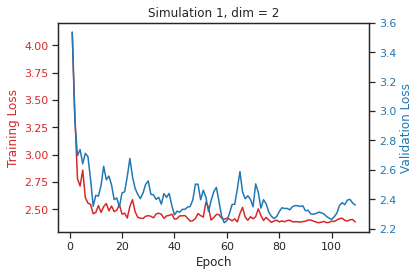

In [54]:
fig, ax1 = plt.subplots()
epochs = range(1, len(best_overall['train_history']) + 1)
color1 = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Training Loss', color=color1)
ax1.plot(epochs, best_overall['train_history'], color=color1, label='Training Loss')
ax1.tick_params(axis='y', labelcolor=color1)

# Validation loss is calculated every 20 epochs.
# Create a list of epochs corresponding to validation measurements

# Create a second y-axis for validation loss
ax2 = ax1.twinx()
color2 = 'tab:blue'
ax2.set_ylabel('Validation Loss', color=color2)
ax2.plot(epochs, best_overall['val_history'], color=color2, label='Validation Loss')
ax2.tick_params(axis='y', labelcolor=color2)

plt.title('Simulation 1, dim = 2')


# sns.set(style="ticks",font_scale=1)
plt.tight_layout()
plt.savefig(dir_out + 'Plots/'+'Train_val_loss_simulation_1_dim_2.pdf',bbox_inches='tight')
plt.show()

In [23]:
dir_out

'/home/pgrad2/2448355h/My_PhD_Project/01_Output/GPDFlow/'

In [30]:
dim = 5
base = nf.distributions.DiagGaussian(dim)


num_layers = 8
torch.manual_seed(0)

latent_size = dim
b = torch.Tensor([1 if i % 2 == 0 else 0 for i in range(latent_size)])
flows = []
for i in range(num_layers):
    s = nf.nets.MLP([latent_size, 4 * latent_size, latent_size], init_zeros=True, output_fn='tanh')
    t = nf.nets.MLP([latent_size, 4 * latent_size, latent_size], init_zeros=True, output_fn='tanh')
    if i % 2 == 0:
        flows += [nf.flows.MaskedAffineFlow(b, t, s)]
    else:
        flows += [nf.flows.MaskedAffineFlow(1 - b, t, s)]
    flows += [nf.flows.ActNorm(latent_size)]


f_T_model = nf.NormalizingFlow(base, flows)
f_T_model = f_T_model.to(device)

batch_size = 64
loss_history = []
epochs = 200

model = T_mGPD_NF(dim=dim, flow =f_T_model, device=device, s_min=-10,
                  s_max = 10, num_integration_points=1000, penalty_lambda=10000, fix_margin=False)

optimizer = torch.optim.Adam([
    {'params': model.flow_model.parameters(), 'lr': 1e-2},  # Flow layers
    {'params': model.data_transform.log_sigma, 'lr': 1e-1},  # Faster for log_sigma
    {'params': model.data_transform.theta, 'lr': 1e-1}       # Faster for gamma
], weight_decay = 1e-5 )

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs)

seed = 1234
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # for multi-GPU setups

# Make tensors
train_data = torch.tensor(np.asarray(train_samples), dtype=torch.float32, device=device)
val_data   = torch.tensor(np.asarray(val_samples),   dtype=torch.float32, device=device)

# DataLoaders (shuffle ONLY train)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True,  drop_last=False)
val_loader   = DataLoader(val_data,   batch_size=batch_size, shuffle=False, drop_last=False)

# ---- Early stopping config ----
patience = 100          # how many epochs w/o improvement before stopping
min_delta = 0.0        # minimum improvement to reset patience
best_val = float("inf")
best_state = None
bad_epochs = 0

train_loss_history = []
val_loss_history = []
loss_history = []  # keep your original per-batch history if you want

torch.autograd.set_detect_anomaly(True)

for epoch in range(epochs):
    # ---------------- TRAIN ----------------
    model.train()
    train_epoch_loss = 0.0
    train_count = 0

    for x_data in train_loader:
        # x_data shape: [B, dim] (or whatever your model expects)
        batch_loss = model(x_data)

        if torch.isnan(batch_loss) or torch.isinf(batch_loss):
            print(f"[Epoch {epoch}] NaN/Inf detected in TRAIN loss. Stopping.")
            bad_epochs = patience
            break

        optimizer.zero_grad(set_to_none=True)
        batch_loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        bsz = x_data.shape[0]
        train_epoch_loss += batch_loss.item() * bsz
        train_count += bsz

        loss_history.append(batch_loss.item())  # per-batch (optional)

    if train_count > 0:
        train_epoch_loss /= train_count
    train_loss_history.append(train_epoch_loss)

    # ---------------- VALIDATION ----------------
    model.eval()
    val_epoch_loss = 0.0
    val_count = 0
    with torch.no_grad():
        for x_val in val_loader:
            val_loss = model(x_val)

            if torch.isnan(val_loss) or torch.isinf(val_loss):
                print(f"[Epoch {epoch}] NaN/Inf detected in VAL loss. Stopping.")
                bad_epochs = patience
                break

            bsz = x_val.shape[0]
            val_epoch_loss += val_loss.item() * bsz
            val_count += bsz

    if val_count > 0:
        val_epoch_loss /= val_count
    val_loss_history.append(val_epoch_loss)

    # Scheduler step (keep same behavior as your code: step per epoch)
    scheduler.step()

    # ---------------- LOGGING ----------------
    print(
        f"Epoch {epoch+1:4d}/{epochs} | "
        f"train_loss={train_epoch_loss:.6f} | val_loss={val_epoch_loss:.6f} | "
        f"lr={scheduler.get_last_lr()[0]:.3e}"
    )

    # ---------------- EARLY STOPPING (monitor val, but you can also use train) ----------------
    # Primary early-stop signal: validation loss improvement.
    improved = (best_val - val_epoch_loss) > min_delta
    if improved:
        best_val = val_epoch_loss
        bad_epochs = 0
        # Save best weights (CPU copy so it's safe)
        best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
    else:
        bad_epochs += 1

    # Optional: also guard against train/val divergence (overfitting)
    # Example: stop if val is consistently worsening while train keeps improving.
    # (Simple heuristic; comment out if you don't want it.)
    if len(val_loss_history) > 5:
        if val_loss_history[-1] > min(val_loss_history[:-1]) and train_loss_history[-1] < min(train_loss_history[:-1]):
            pass  # keep training; heuristic could be implemented if desired

    if bad_epochs >= patience:
        print(f"Early stopping at epoch {epoch+1} (no val improvement for {patience} epochs).")
        break

# Restore best model (recommended)
if best_state is not None:
    model.load_state_dict({k: v.to(device) for k, v in best_state.items()})
    print(f"Restored best model with val_loss={best_val:.6f}")

Epoch    1/200 | train_loss=12.704103 | val_loss=10.410941 | lr=9.999e-03
Epoch    2/200 | train_loss=10.605514 | val_loss=8.909759 | lr=9.998e-03
Epoch    3/200 | train_loss=9.118334 | val_loss=8.327967 | lr=9.994e-03
Epoch    4/200 | train_loss=9.493282 | val_loss=8.781287 | lr=9.990e-03
Epoch    5/200 | train_loss=9.149386 | val_loss=8.803536 | lr=9.985e-03
Epoch    6/200 | train_loss=8.559971 | val_loss=8.638770 | lr=9.978e-03
Epoch    7/200 | train_loss=8.222400 | val_loss=8.283759 | lr=9.970e-03
Epoch    8/200 | train_loss=8.101697 | val_loss=8.166174 | lr=9.961e-03
Epoch    9/200 | train_loss=8.023873 | val_loss=8.190471 | lr=9.950e-03
Epoch   10/200 | train_loss=7.907504 | val_loss=8.691344 | lr=9.938e-03
Epoch   11/200 | train_loss=7.991536 | val_loss=9.248971 | lr=9.926e-03
Epoch   12/200 | train_loss=7.960624 | val_loss=8.710855 | lr=9.911e-03
Epoch   13/200 | train_loss=7.811813 | val_loss=8.480234 | lr=9.896e-03
Epoch   14/200 | train_loss=7.788664 | val_loss=8.286628 | lr

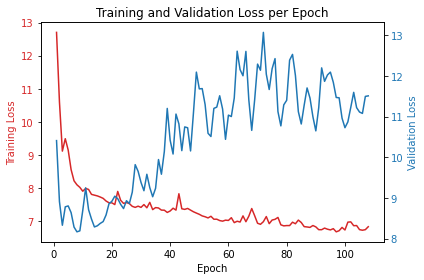

In [32]:
fig, ax1 = plt.subplots()
epochs = range(1, len(train_loss_history) + 1)
color1 = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Training Loss', color=color1)
ax1.plot(epochs, train_loss_history, color=color1, label='Training Loss')
ax1.tick_params(axis='y', labelcolor=color1)

# Validation loss is calculated every 20 epochs.
# Create a list of epochs corresponding to validation measurements

# Create a second y-axis for validation loss
ax2 = ax1.twinx()
color2 = 'tab:blue'
ax2.set_ylabel('Validation Loss', color=color2)
ax2.plot(epochs, val_loss_history, color=color2, label='Validation Loss')
ax2.tick_params(axis='y', labelcolor=color2)

plt.title('Training and Validation Loss per Epoch')
fig.tight_layout()
plt.show()

#### Fit a GPDFlow on the simulated data. Repeat for 100 times

In [60]:
dim = 5
base = nf.distributions.DiagGaussian(dim)

with open(dir_out + f"/res_grid_search_simulation_1_dim_{dim}.pkl", "rb") as f:
    res_list = pickle.load(f)
best_overall = res_list[1]

hidden_mult = best_overall['hidden_mult']
num_layers = best_overall['num_layers']
epochs = best_overall['best_epoch']


torch.manual_seed(0)

latent_size = dim
b = torch.Tensor([1 if i % 2 == 0 else 0 for i in range(latent_size)])
flows = []
for i in range(num_layers):
    s = nf.nets.MLP([latent_size, hidden_mult * latent_size, latent_size], init_zeros=True, output_fn='tanh')
    t = nf.nets.MLP([latent_size, hidden_mult * latent_size, latent_size], init_zeros=True, output_fn='tanh')
    if i % 2 == 0:
        flows += [nf.flows.MaskedAffineFlow(b, t, s)]
    else:
        flows += [nf.flows.MaskedAffineFlow(1 - b, t, s)]
    flows += [nf.flows.ActNorm(latent_size)]


f_T_model = nf.NormalizingFlow(base, flows)
f_T_model = f_T_model.to(device)

batch_size = 64
loss_history = []


model = T_mGPD_NF(dim=dim, flow =f_T_model, device=device, s_min=-10,
                  s_max = 10, num_integration_points=1000, penalty_lambda=10000, fix_margin=False)

optimizer = torch.optim.Adam([
    {'params': model.flow_model.parameters(), 'lr': 1e-2},  # Flow layers
    {'params': model.data_transform.log_sigma, 'lr': 1e-1},  # Faster for log_sigma
    {'params': model.data_transform.theta, 'lr': 1e-1}       # Faster for gamma
], weight_decay = 1e-5 )

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs)

seed = 1234
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # for multi-GPU setups

for i in range(n_experiments):
    

    samples = cf.sim_revexp_T_mgpd(n_samples, dim, a, beta, sig, gamma)

    data = torch.tensor(samples, dtype=torch.float, device = device)

    memory = torch.cuda.memory_allocated(device) /10**9

    Training_Data = DataLoader(data, batch_size=batch_size, shuffle=True)
    torch.autograd.set_detect_anomaly(True)

    for epoch in range(epochs):
        epoch_loss = 0.0
        
        for x_data in Training_Data:
            # Sample a batch of data from h_U

            batch_loss = model(x_data)

            # Backpropagation
            optimizer.zero_grad()
            batch_loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
            optimizer.step()

            # Record loss
            loss_history.append(batch_loss.item())
            epoch_loss += batch_loss.item()

            if torch.isnan(batch_loss) or torch.isinf(batch_loss):
                print("NaN or Inf detected!")
                break

        # Debugging: Print shapes
        scheduler.step()
    torch.save(model.state_dict(), dir_out + f'model_{dim}D_100_{i}.pt')
    print(f"Completed Experiment {i} \n")



Completed Experiment 0 

Completed Experiment 1 

Completed Experiment 2 

Completed Experiment 3 

Completed Experiment 4 

Completed Experiment 5 

Completed Experiment 6 

Completed Experiment 7 

Completed Experiment 8 

Completed Experiment 9 

Completed Experiment 10 

Completed Experiment 11 

Completed Experiment 12 

Completed Experiment 13 

Completed Experiment 14 

Completed Experiment 15 

Completed Experiment 16 

Completed Experiment 17 

Completed Experiment 18 

Completed Experiment 19 

Completed Experiment 20 

Completed Experiment 21 

Completed Experiment 22 

Completed Experiment 23 

Completed Experiment 24 

Completed Experiment 25 

Completed Experiment 26 

Completed Experiment 27 

Completed Experiment 28 

Completed Experiment 29 

Completed Experiment 30 

Completed Experiment 31 

Completed Experiment 32 

Completed Experiment 33 

Completed Experiment 34 

Completed Experiment 35 

Completed Experiment 36 

Completed Experiment 37 

Completed Experiment 3

#### Compare the true $f_{\boldsymbol{T}}$ and fitted $f_{\boldsymbol{T}}$ from the normalizing flow

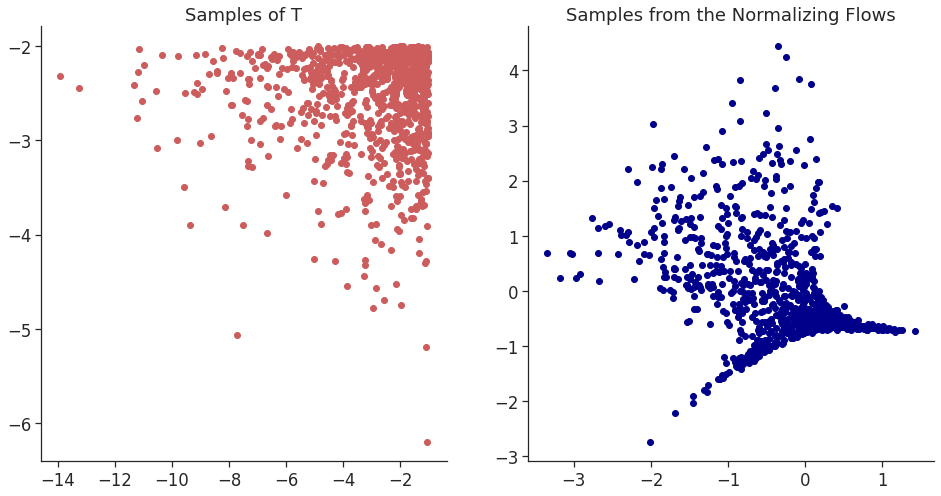

In [12]:
seed = 1234
n = 1000
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # for multi-GPU setups

T_total = []
for j in range(d):
    U = np.random.uniform(0, 1, n)
    T = a[j]*np.log(U) - beta[j]
    T_total.append(T)
T_total = np.column_stack(T_total)

model = cf.GPDFlow(2)

sns.set(style="ticks",font_scale=1.5)
plt.figure(figsize=(16,8))
plt.subplot(1, 2, 1)
plt.scatter(T_total[:,0], T_total[:,1], alpha=1, color='indianred')
model.load_state_dict(torch.load(dir_out + f'model_{2}D_100_{0}.pt', weights_only=True))
model.eval()
samples_obs, samples_std, samples_T= model.sample(n)
plt.title('Samples of T')

plt.subplot(1, 2, 2)
plt.scatter(samples_T[:,0].cpu().data.numpy(), samples_T[:,1].cpu().data.numpy(), alpha=1, color='darkblue')
plt.title('Samples from the Normalizing Flows')


sns.despine()
plt.savefig(dir_out + 'Plots/'+'f_T_sample.pdf',bbox_inches='tight')
plt.show()

#### Calculate the theorical pairwise $\chi$ based on formula in Kirkiriliouk's paper

In [57]:
chi_values_theorical = cf.pairwise_chi_theorical(1/a)
chi_values_theorical

{'1-2': np.float64(0.5959389821791157),
 '1-3': np.float64(0.5645351568385462),
 '1-4': np.float64(0.3598892916940263),
 '1-5': np.float64(0.5318610619613964),
 '2-3': np.float64(0.71875),
 '2-4': np.float64(0.40792321620687566),
 '2-5': np.float64(0.6507777482864301),
 '3-4': np.float64(0.39186245321194657),
 '3-5': np.float64(0.612201755794261),
 '4-5': np.float64(0.3754625539543247)}

#### Calculate the empirical $\chi$ from the GPDFlow by 10000 Monte Carlo samples

In [62]:
def GPDFlow(dim):
    """
    A quick set up of a GPDFlow with the architecture in the simulation section.

    Args: 
        dim (integer): dimension of the model
        model (NN.module): GPDFlow with initialization
        n_monte_carlo: number of samples from the model for monte carlo estimations
        n_experiments: number of repeat of the simulation scenario  
    
    Returns:
        model (NN.module): GPDFlow
    
    """
    base = nf.distributions.DiagGaussian(dim)

    with open(dir_out + f"/res_grid_search_simulation_1_dim_{dim}.pkl", "rb") as f:
        res_list = pickle.load(f)
    best_overall = res_list[1]

    hidden_mult = best_overall['hidden_mult']
    num_layers = best_overall['num_layers']

    torch.manual_seed(0)

    latent_size = dim
    b = torch.Tensor([1 if i % 2 == 0 else 0 for i in range(latent_size)])
    flows = []
    for i in range(num_layers):
        s = nf.nets.MLP([latent_size, hidden_mult * latent_size, latent_size], init_zeros=True, output_fn='tanh')
        t = nf.nets.MLP([latent_size, hidden_mult * latent_size, latent_size], init_zeros=True, output_fn='tanh')
        if i % 2 == 0:
            flows += [nf.flows.MaskedAffineFlow(b, t, s)]
        else:
            flows += [nf.flows.MaskedAffineFlow(1 - b, t, s)]
        flows += [nf.flows.ActNorm(latent_size)]


    f_T_model = nf.NormalizingFlow(base, flows)
    f_T_model = f_T_model.to(device)



    model = T_mGPD_NF(dim=dim, flow =f_T_model, device=device, s_min=-10,
                    s_max = 10, num_integration_points=1000, penalty_lambda=10000, fix_margin=False)
    return model


def pairwise_chi_empirical(dim, n_monte_carlo, n_experiments=100):
    """
    Load the esimated Calculate the all empirical pairwise chi(p) of the data simulated by GPDFlow

    Args: 
        dim (integer): dimension of the model
        model (NN.module): GPDFlow with initialization
        n_monte_carlo: number of samples from the model for monte carlo estimations
        n_experiments: number of repeat of the simulation scenario  
    
    Returns:
        sample_chi (dict): dictionary with the name of dimension pairs as the key and a list of
        empirical chi in all experiments as the value
    """

    # Compute lambda_u for each quantile
    model = GPDFlow(dim)
    sample_chi = {}
    for i in range(dim-1):
        for j in range(i+1,dim):
            chi_values = []
            for _ in range(n_experiments):  # Step 3: Repeat 200 times
                # load the estimated weight
                model.load_state_dict(torch.load(dir_out + f'model_{dim}D_100_{_}.pt', weights_only=True))
                model.eval()
                samples_obs, samples_std, samples_T= model.sample(n_monte_carlo)
                sampled_data = samples_obs.cpu().data.numpy()
                chi_values.append(cf.empirical_upper_tail_dependence(sampled_data[:,[i,j]], 0.99))
            sample_chi[f"{i+1}-{j+1}"] =  chi_values
    
    return sample_chi


chi_values_empipical_2 = pairwise_chi_empirical(dim=2,  n_monte_carlo=10000)
chi_values_empipical_3 = pairwise_chi_empirical(dim=3,  n_monte_carlo=10000)
chi_values_empipical_5 = pairwise_chi_empirical(dim=5,  n_monte_carlo=10000)

#### Compare the fitted $\chi$ with the true value

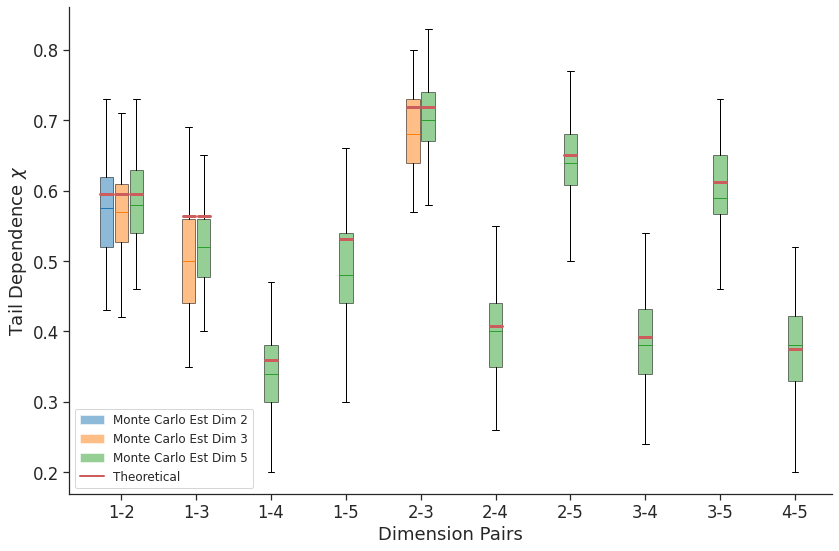

In [69]:
pairs = ['1-2', '1-3', '1-4', '1-5', '2-3', '2-4', '2-5', '3-4', '3-5', '4-5']

# Use the keys from the 5-dimensional dictionary as the full set of pairs.
all_keys = sorted(chi_values_empipical_5.keys())  # sorted in lexicographical order; adjust as needed
x_positions = np.arange(len(all_keys))

delta = 0.2  # spacing factor for box positions

sns.set(style="ticks", font_scale=1.5)
fig, ax = plt.subplots(figsize=(12, 8))

# Prepare a mapping from each key to a list of tuples (dimension, data)
# We use all_keys as the base so that the x-axis remains consistent.
data_by_key = {key: [] for key in all_keys}
for dim, chi_dict in [(2, chi_values_empipical_2),
                      (3, chi_values_empipical_3),
                      (5, chi_values_empipical_5)]:
    for key, data in chi_dict.items():
        if key in data_by_key:
            data_by_key[key].append((dim, data))

colors = {2: '#1f77b4', 3: '#ff7f0e', 5: '#2ca02c'}
alpha_value = 0.5

# Loop over each key and plot the boxplots for the dimensions available.
for i, key in enumerate(all_keys):
    # Sort by dimension to maintain a consistent order (2, then 3, then 5)
    items = sorted(data_by_key[key], key=lambda x: x[0])
    n = len(items)
    if n == 0:
        continue  
    # Compute offsets so that the available boxplots are centered.
    offsets = [ (j - (n-1)/2) * delta for j in range(n) ]
    # Plot each available boxplot at the computed offset
    for offset, (dim, data) in zip(offsets, items):
        pos = x_positions[i] + offset
        bp = ax.boxplot(data, positions=[pos], widths=0.18,
                        patch_artist=True, showfliers=False)
        for patch in bp['boxes']:
            patch.set_facecolor(colors[dim])
            patch.set_alpha(alpha_value)
        for median in bp['medians']:
            median.set_color(colors[dim])
        # Plot the theoretical line if available.
        if key in chi_values_theorical:
            theory_val = chi_values_theorical[key]
            ax.plot([pos - 0.08, pos + 0.08],
                    [theory_val, theory_val],
                    color='indianred', lw=3)

# Set x-axis labels.
ax.set_xticks(x_positions)
ax.set_xticklabels(all_keys)
ax.set_xlabel("Dimension Pairs")
ax.set_ylabel(r"Tail Dependence $\chi$")

# Add legend.
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=colors[dim], label=f'Monte Carlo Est Dim {dim}', alpha=alpha_value) for dim in [2, 3, 5]]
legend_elements.append(plt.Line2D([0], [0], color='indianred', lw=2, label='Theoretical'))
ax.legend(handles=legend_elements, loc='lower left',fontsize=12)
sns.despine()
plt.tight_layout()
plt.savefig(dir_out + 'Plots/'+f'Simulation_1_chi.pdf',bbox_inches='tight')
plt.show()

#### Get the estimated $\boldsymbol{\sigma}$ and $\boldsymbol{\gamma}$.

To get the estimated $\boldsymbol{\sigma}$ and $\boldsymbol{\gamma}$ from a single GPDFlow object called "model", one can use the following code:

model.data_transform.get_sigma()

model.data_transform.get_gamma()

In [65]:
def marginal_parameter_monte_carlo(dim, n_experiments=100):
    """
    Load the estimated sigma and gamma of GPDFlow models in a simulation scenario, 
    and save them in two dictionaries.
    
    Args: 
        dim (integer): dimension of the model.
        n_experiments (integer): Number of repeat of the simulation
    
    Returns:
        sigma_dict(dict)， gamma_dict(dict): two dictionaries contains the estimated sigma and gamma of 
        GPDFlow models in a simulation scenario. 
    
    """
    sigma_dict = {f'{i+1}': [] for i in range(dim)}
    gamma_dict = {f'{i+1}': [] for i in range(dim)}
    model = GPDFlow(dim)
    for _ in range(n_experiments):  # Step 3: Repeat 200 times
        model.load_state_dict(torch.load(dir_out + f'model_{dim}D_100_{_}.pt', weights_only=True))
        model.eval()
        sigma_hat = model.data_transform.get_sigma().cpu().data.numpy()
        gamma_hat = model.data_transform.get_gamma().cpu().data.numpy()
        for i in range(dim):
            sigma_dict[f'{i+1}'].append(sigma_hat[i])
            gamma_dict[f'{i+1}'].append(gamma_hat[i])
    return sigma_dict, gamma_dict
sigma_dict_2, gamma_dict_2 = marginal_parameter_monte_carlo(2)
sigma_dict_3, gamma_dict_3 = marginal_parameter_monte_carlo(3)
sigma_dict_5, gamma_dict_5 = marginal_parameter_monte_carlo(5)

In [66]:
sigma_true = dict(zip(['1', '2', '3', '4', '5'], sig))
gamma_true = dict(zip(['1', '2', '3', '4', '5'], gamma))

#### Compare the fitted $\boldsymbol{\sigma}$ with true values

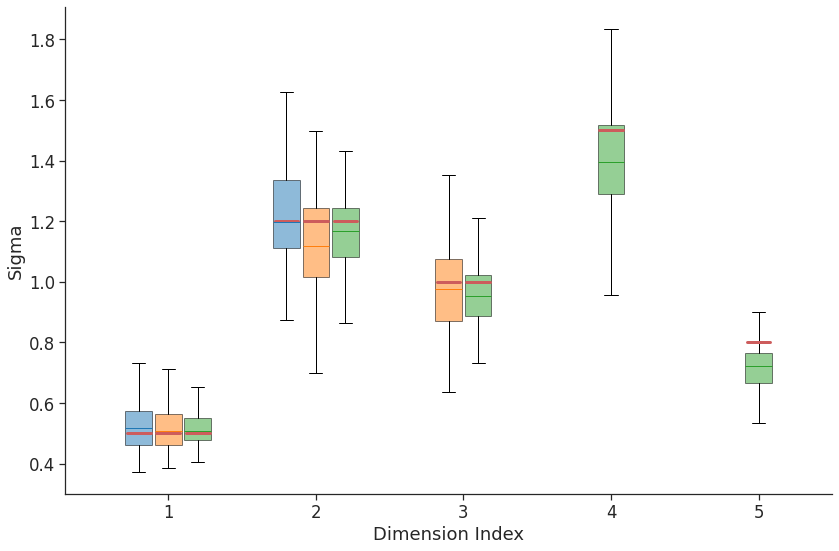

In [70]:
pairs = ['1', '2', '3', '4', '5']

# Use the keys from the 5-dimensional dictionary as the full set of pairs.
all_keys = sorted(sigma_dict_5.keys())  
x_positions = np.arange(len(all_keys))

delta = 0.2  # spacing factor for box positions

sns.set(style="ticks", font_scale=1.5)
fig, ax = plt.subplots(figsize=(12, 8))

# Prepare a mapping from each key to a list of tuples (dimension, data)
# We use all_keys as the base so that the x-axis remains consistent.
data_by_key = {key: [] for key in all_keys}
for dim, chi_dict in [(2, sigma_dict_2),
                      (3, sigma_dict_3),
                      (5, sigma_dict_5)]:
    for key, data in chi_dict.items():
        if key in data_by_key:
            data_by_key[key].append((dim, data))

colors = {2: '#1f77b4', 3: '#ff7f0e', 5: '#2ca02c'}
alpha_value = 0.5

# Loop over each key and plot the boxplots for the dimensions available.
for i, key in enumerate(all_keys):
    # Sort by dimension to maintain a consistent order (2, then 3, then 5)
    items = sorted(data_by_key[key], key=lambda x: x[0])
    n = len(items)
    if n == 0:
        continue 
    # Compute offsets so that the available boxplots are centered.
    offsets = [ (j - (n-1)/2) * delta for j in range(n) ]
    # Plot each available boxplot at the computed offset
    for offset, (dim, data) in zip(offsets, items):
        pos = x_positions[i] + offset
        bp = ax.boxplot(data, positions=[pos], widths=0.18,
                        patch_artist=True, showfliers=False)
        for patch in bp['boxes']:
            patch.set_facecolor(colors[dim])
            patch.set_alpha(alpha_value)
        for median in bp['medians']:
            median.set_color(colors[dim])
        # Plot the theoretical line if available.
        if key in sigma_true:
            theory_val = sigma_true[key]
            ax.plot([pos - 0.08, pos + 0.08],
                    [theory_val, theory_val],
                    color='indianred', lw=3)

# Set x-axis labels.
ax.set_xticks(x_positions)
ax.set_xticklabels(all_keys)
ax.set_xlabel("Dimension Index")
ax.set_ylabel("Sigma")
# ax.set_title("Empirical Tail Dependence Boxplots with Theoretical Lines")

# Add legend.
# from matplotlib.patches import Patch
# legend_elements = [Patch(facecolor=colors[dim], label=f'Monte Calro Results in Dim {dim}', alpha=alpha_value) for dim in [2, 3, 5]]
# legend_elements.append(plt.Line2D([0], [0], color='darkorange', lw=2, label='Theoretical'))
# ax.legend(handles=legend_elements, loc='best',fontsize=15)
sns.despine()
plt.tight_layout()
plt.savefig(dir_out + 'Plots/'+f'Simulation_1_sigma.pdf',bbox_inches='tight')
plt.show()

#### Compare the fitted $\boldsymbol{\gamma}$ with true values

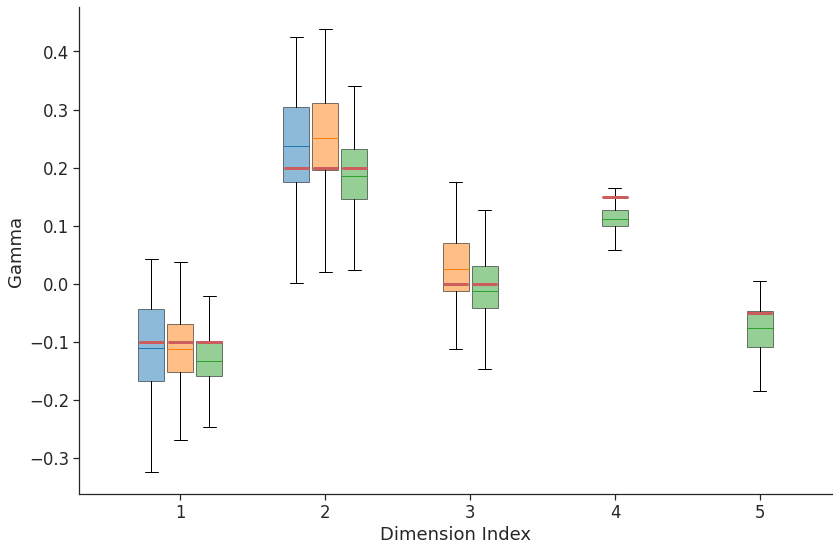

In [71]:
pairs = ['1', '2', '3', '4', '5']

# Use the keys from the 5-dimensional dictionary as the full set of pairs.
all_keys = sorted(gamma_dict_5.keys())  
x_positions = np.arange(len(all_keys))

delta = 0.2  # spacing factor for box positions

sns.set(style="ticks", font_scale=1.5)
fig, ax = plt.subplots(figsize=(12, 8))

# Prepare a mapping from each key to a list of tuples (dimension, data)
# We use all_keys as the base so that the x-axis remains consistent.
data_by_key = {key: [] for key in all_keys}
for dim, chi_dict in [(2, gamma_dict_2),
                      (3, gamma_dict_3),
                      (5, gamma_dict_5)]:
    for key, data in chi_dict.items():
        if key in data_by_key:
            data_by_key[key].append((dim, data))

colors = {2: '#1f77b4', 3: '#ff7f0e', 5: '#2ca02c'}
alpha_value = 0.5

# Loop over each key and plot the boxplots for the dimensions available.
for i, key in enumerate(all_keys):
    # Sort by dimension to maintain a consistent order (2, then 3, then 5)
    items = sorted(data_by_key[key], key=lambda x: x[0])
    n = len(items)
    if n == 0:
        continue 
    # Compute offsets so that the available boxplots are centered.
    offsets = [ (j - (n-1)/2) * delta for j in range(n) ]
    # Plot each available boxplot at the computed offset
    for offset, (dim, data) in zip(offsets, items):
        pos = x_positions[i] + offset
        bp = ax.boxplot(data, positions=[pos], widths=0.18,
                        patch_artist=True, showfliers=False)
        for patch in bp['boxes']:
            patch.set_facecolor(colors[dim])
            patch.set_alpha(alpha_value)
        for median in bp['medians']:
            median.set_color(colors[dim])
        # Plot the theoretical line if available.
        if key in gamma_true:
            theory_val = gamma_true[key]
            ax.plot([pos - 0.08, pos + 0.08],
                    [theory_val, theory_val],
                    color='indianred', lw=3)
                
# Set x-axis labels.
ax.set_xticks(x_positions)
ax.set_xticklabels(all_keys)
ax.set_xlabel("Dimension Index")
ax.set_ylabel("Gamma")
# ax.set_title("Empirical Tail Dependence Boxplots with Theoretical Lines")

# Add legend.
# from matplotlib.patches import Patch
# legend_elements = [Patch(facecolor=colors[dim], label=f'Monte Calro Results in Dim {dim}', alpha=alpha_value) for dim in [2, 3, 5]]
# legend_elements.append(plt.Line2D([0], [0], color='darkorange', lw=2, label='Theoretical'))
# ax.legend(handles=legend_elements, loc='best',fontsize=15)
sns.despine()
plt.tight_layout()
plt.savefig(dir_out + 'Plots/'+f'Simulation_1_gamma.pdf',bbox_inches='tight')
plt.show()